# Time series forecasting

In [1]:
import pprint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

from reservoir_computing.modules import RC_forecaster
from reservoir_computing.utils import make_forecasting_dataset
from reservoir_computing.datasets import PredLoader

np.random.seed(0) # For reproducibility

## Configure the RC model

In [2]:
config = {}

# Reservoir
config['n_internal_units'] = 900        # size of the reservoir
config['spectral_radius'] = 0.95        # largest eigenvalue of the reservoir
config['leak'] = None                   # amount of leakage in the reservoir state update (None or 1.0 --> no leakage)
config['connectivity'] = 0.25           # percentage of nonzero connections in the reservoir
config['input_scaling'] = 0.1           # scaling of the input weights
config['noise_level'] = 0.0             # noise in the reservoir state update
config['n_drop'] = 10                   # transient states to be dropped
config['circle'] = False                # use reservoir with circle topology

# Dimensionality reduction
config['dimred_method'] = 'pca'         # options: {None (no dimensionality reduction), 'pca'}
config['n_dim'] = 75                    # number of resulting dimensions after the dimensionality reduction procedure

# Linear readout
config['w_ridge'] = 1.0                 # regularization of the ridge regression readout

pprint.pprint(config)

{'circle': False,
 'connectivity': 0.25,
 'dimred_method': 'pca',
 'input_scaling': 0.1,
 'leak': None,
 'n_dim': 75,
 'n_drop': 10,
 'n_internal_units': 900,
 'noise_level': 0.0,
 'spectral_radius': 0.95,
 'w_ridge': 1.0}


## Prepare the data

In [3]:
# Load the dataset
ts_full = PredLoader().get_data('ElecRome')

Loaded ElecRome dataset.
Data shape:
  X: (137376, 1)


In [4]:
# Resample the time series to hourly frequency
ts_hourly = np.mean(ts_full.reshape(-1, 6), axis=1)
print(ts_hourly.shape)

(22896,)


In [5]:
# Use only the first 3000 time steps
ts_small = ts_hourly[0:3000, None]
print(ts_small.shape)

(3000, 1)


In [6]:
# Generate training and testing datasets
Xtr, Ytr, Xte, Yte, scaler = make_forecasting_dataset(
    ts_small, 
    horizon=24, # forecast horizon of 24h ahead
    test_percent = 0.1)

print(f"Xtr shape: {Xtr.shape}\nYtr shape: {Ytr.shape}\nXte shape: {Xte.shape}\nYte shape: {Yte.shape}")

Xtr shape: (2676, 2)
Ytr shape: (2676, 1)
Xte shape: (276, 2)
Yte shape: (276, 1)


## Train the RC model and make predictions

In [7]:
# Initialize the RC model 
forecaster =  RC_forecaster(**config)

In [8]:
# Train the model
forecaster.fit(Xtr, Ytr)

Training completed in 0.00 min


In [9]:
# Compute predictions on test data
Yhat = forecaster.predict(Xte)
Yhat = scaler.inverse_transform(Yhat) # Revert the scaling of the predictions 
mse = mean_squared_error(Yte[config['n_drop']:,:], Yhat)
print(f"Mean Squared Error: {mse:.2f}")

Mean Squared Error: 22.01


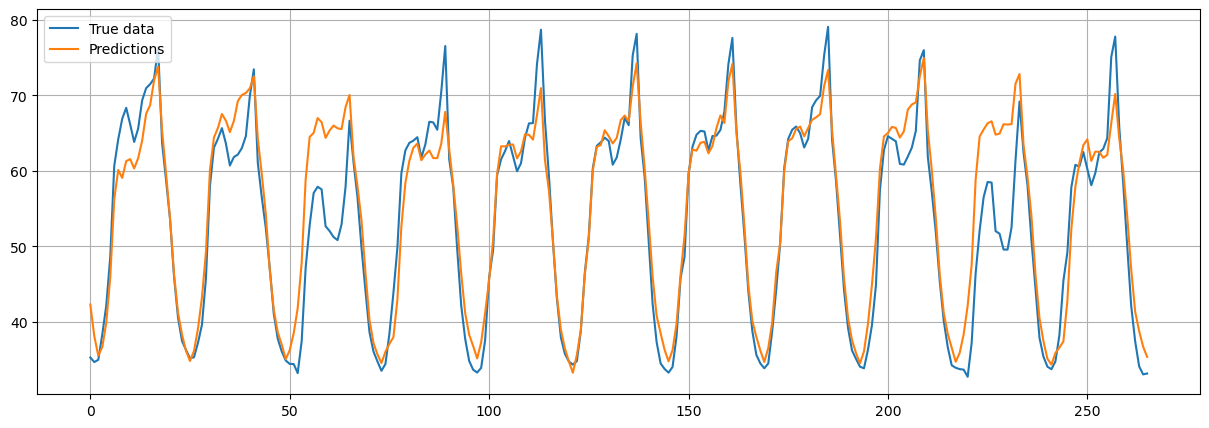

In [10]:
# Plot the predictions
plt.figure(figsize=(15, 5))
plt.plot(Yte[config['n_drop']:,:], label='True data')
plt.plot(Yhat, label='Predictions')
plt.legend()
plt.grid()
plt.show()